<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch3_%EC%8B%A4%EC%8A%B5_Fashion_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3-5. Deep Learning 기초 : Multi Layer Perceptron (MLP)

>## 실습 : Fashion-MNIST Classification (MLP)

>### Load modules

In [1]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0
Matplotlib Version :3.1.2


> ### Load MNIST Data

In [23]:
fashion_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Data Load : x_input, labels와 같이 학습/테스트에 필요한 데이터셋 및 정답 
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

# Data Set
print(type(train_data), train_data.shape) # 60,000개의 데이터
print(type(test_data), test_data.shape)   # 10,000개의 데이터

train_data = train_data.astype(np.float32)
train_data = train_data / 255.0             # 수업 예제처럼 Overflow를 방지하고자 255.0으로 나눠줌  ( grayscale - 0 ~ 255 )
                                            # && sigmoid(logits)의 결과로 나오는 것은 0 ~ 1 사이의 값, 즉 확률. 애초에 input layer 때부터 데이터 가공(Scaling)

train_fashion_cnt = np.zeros((10,), dtype=np.int32)
for i in range(60000):
  for j in range(10):
    if train_labels[i] == j:
      train_fashion_cnt[j] += 1
print(train_fashion_cnt)

test_fashion_cnt = np.zeros((10,), dtype=np.int32)
for i in range(10000):
  for j in range(10):
    if test_labels[i] == j:
      test_fashion_cnt[j] += 1
print(test_fashion_cnt)


test_data = test_data.astype(np.float32)
test_data = test_data / 255.0

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

print(type(train_labels), train_labels.shape)
print(type(test_labels), test_labels.shape)


<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (10000, 28, 28)
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
<class 'numpy.ndarray'> (60000, 1)
<class 'numpy.ndarray'> (10000, 1)




> ## Placeholder



In [0]:
x_ph = tf.placeholder(tf.float32, shape=(None, 28, 28), name = "input")   # batch size는 유동적, size는 28 * 28
labels_ph = tf.placeholder(tf.int32, shape=(None,1), name="labels")       # batch size는 유동적, 결과값은 scalar / 그리고 의류 종류를 정수로 나타냄



> ## Categories, Learning Rate


In [0]:
categories = 10           # 옷 종류 : 0 ~ 9로 총 10개
learning_rate = 0.001     # 적당한 수준 몰라서 이전 예제에서 가져옴



> ## Layer Design - including Hidden Layer // Hypothesis, Cost, Optimizer



In [5]:
# input layer (784) -> hidden layer (1024)
x_flatten = tf.layers.flatten(x_ph)
                                         # activation function=sigmoid, -------------weight initializer-------------   --------bias initializer--------
layer1 = tf.layers.dense(x_flatten, 1024, activation=tf.nn.sigmoid, kernel_initializer=tf.glorot_uniform_initializer, bias_initializer=tf.glorot_uniform_initializer)
layer1_bn = tf.layers.batch_normalization(layer1) # Batch Normalization : 학습 시, layers 간 입력 분포 왜곡 현상 해소 및 학습 효율성 증대
# => layer1의 shape = (batch size, 1024)

# hidden layer (1024) -> output layer (512)
                                         # activation function=sigmoid, ------------weight initializer------------   --------bias initializer--------
layer2 = tf.layers.dense(layer1_bn, 512, activation=tf.nn.sigmoid, kernel_initializer=tf.glorot_uniform_initializer, bias_initializer=tf.glorot_uniform_initializer)
layer2_bn = tf.layers.batch_normalization(layer2)
# => layer2의 shape = (batch size, 512)

# for softmax ( 512 -> 10 )
                                                       # --------------weight initializer--------------  -------------bias initializer-------------
layer3_logits = tf.layers.dense(layer2_bn, categories, kernel_initializer=tf.glorot_uniform_initializer, bias_initializer=tf.glorot_uniform_initializer)
              # activation function=softmax
hypothesis = tf.nn.softmax(layer3_logits)
# => hypothesis의 shape = (batch size, 카테고리 수=10)

# One-hot
labels_oh = tf.one_hot(labels_ph, categories)

# Hypothesis, Cost, Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels_oh, layer3_logits))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(cost)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).




> ## Epoch(전체 데이터셋 1회 학습 시키는 단위 횟수), Mini-Batch(작은 batch size)



In [6]:
N_epoch = 500
batch_size = 200
train_data_size = train_data.shape
batch_count = train_data_size[0] //batch_size

print(train_data_size)  # 60,000개의 training data-set
print(batch_count)      # 전체 60,000개의 데이터를 mini-batch 100으로 설정 => 60,000 / 100 == 600개의 mini-batch


(60000, 28, 28)
300




> ## Accuracy Function : 이해하기



In [0]:
  # parameter: hypothesis 결과(확률), label(실제 정답) -> return : float
def Accuracy(y:np.ndarray, t:np.ndarray)->np.float32:
    return np.mean(np.equal(np.argmax(y, axis=1).reshape((-1, 1)),t).astype(np.float32))
                  # 학습 결과물들(의 확률) 중 최대값의 idx(?)와 실제 정답(의류 종류 0 ~ 9 중 하나가 같다면 True, 다르다면 False
                  # 이 bool 값을 .astype(np.float32)으로 실수로 바꿔주고(각각 1. , 0.), 이것의 합의 평균을 리턴!



> ## 결과물 출력을 위한 함수



In [0]:
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(5,2,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        plt.subplots_adjust(left=0.5, right=1.0, top=3.0, bottom=0.5)
        ax_result[idx//2][idx%2].imshow(data[idx].reshape((28,28)),cmap="binary")
        ax_result[idx//2][idx%2].set_title("test_data[{}] (label : {} / y : {})".format(idx, fashion_name[label[idx][0]], fashion_name[y_max[idx][0]]))


def Make_Result_Plot_After_Training(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    false_arr = []
    cnt = 0
    for idx in range(10000):
      if y_max[idx] != label[idx]:
        false_arr.append(idx)
        cnt += 1
    fig_result, ax_result = plt.subplots(5,2,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        plt.subplots_adjust(left=0.5, right=1.0, top=3.0, bottom=0.5)
        ax_result[idx//2][idx%2].imshow(data[idx].reshape((28,28)),cmap="binary")
        ax_result[idx//2][idx%2].set_title("[False] test_data[{}] (label : {} / y : {})".format(idx, fashion_name[label[false_arr[idx]][0]], fashion_name[y_max[false_arr[idx]][0]]))
    print(cnt)




> ## Example : Check Training Data



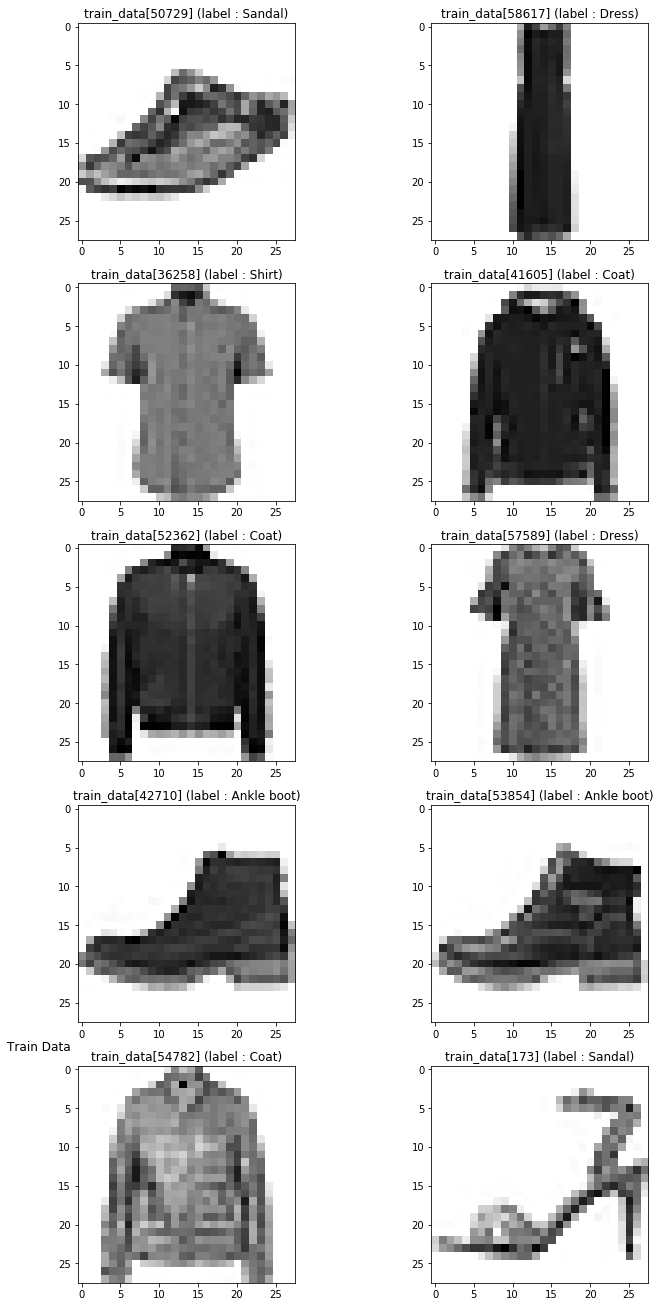

In [9]:
idx_show = np.arange(0, train_data.shape[0])
np.random.shuffle(idx_show)
idx_show = idx_show[0:10]
fig_train, ax_train = plt.subplots(5,2,figsize=(18, 7))
fig_train.suptitle("Train Data")
for idx in range(10):
    plt.subplots_adjust(left=0.5, right=1.0, top=3.0, bottom=0.5)
    ax_train[idx//2][idx%2].imshow(train_data[idx_show[idx]],cmap="binary")
    ax_train[idx//2][idx%2].set_title("train_data[{}] (label : {})".format(idx_show[idx], fashion_name[train_labels[idx_show[idx]][0]]))




> ## Training 준비!



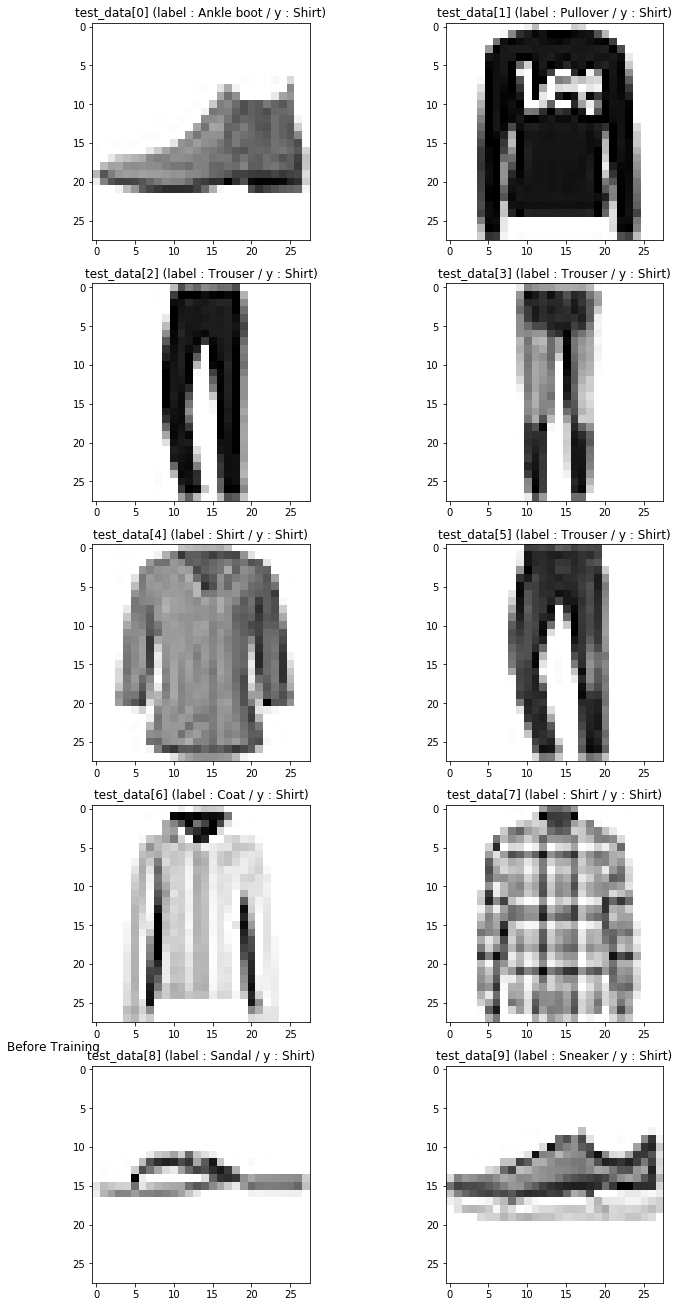

In [10]:
arr_epoch = []
arr_accu = []

# 학습 (Training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_idx = np.arange(train_data_size[0])  # train_data_size은 (60000, 28, 28) : 60,000개의 데이터, 가로*세로 28*28 中 데이터 batch size

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data}) # test_data를 입력하여 나온 hypothesis 결과들을 y_out에 저장(?)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))         # y_out.shape = (batch_size=60,000 , 10==categories)
                                                          # 10개의 의류 중 확률(hypothesis 결과)가 가장 높은 종의 idx를 찾음!
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

accu = Accuracy(y_out,test_labels)
arr_epoch.append(0)
arr_accu.append(accu)



> ## 실제 Training



In [11]:
%%time
# 시간을 측정하기 위한 magic command

for epoch_idx in range(1, N_epoch+1): # 1 ~ 501까지 총 500회
    np.random.shuffle(train_data_idx) # 총 60,000개의 train_data-set을 섞음
    for batch_idx in range(batch_count):  # 600개의 mini_batch
    
                                        # -------- bi*bs + i (0 <= bi < 600, 0 <= bs < 100, 0 <= i < 100) ---------
        batch_data = np.array([train_data[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])
        batch_labels = np.array([train_labels[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])

        sess.run(train, feed_dict={x_ph: batch_data, labels_ph: batch_labels})

    y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
    accu = Accuracy(y_out,test_labels)
    print("[{:>5}] accuracy = {:>10.4}".format(epoch_idx,accu))
    arr_epoch.append(epoch_idx)
    arr_accu.append(accu)


[    1] accuracy =     0.8287
[    2] accuracy =     0.8257
[    3] accuracy =     0.8571
[    4] accuracy =     0.8613
[    5] accuracy =     0.8629
[    6] accuracy =     0.8675
[    7] accuracy =     0.8749
[    8] accuracy =     0.8785
[    9] accuracy =     0.8783
[   10] accuracy =     0.8761
[   11] accuracy =     0.8827
[   12] accuracy =     0.8867
[   13] accuracy =     0.8873
[   14] accuracy =     0.8861
[   15] accuracy =     0.8905
[   16] accuracy =     0.8916
[   17] accuracy =     0.8852
[   18] accuracy =     0.8841
[   19] accuracy =     0.8916
[   20] accuracy =     0.8872
[   21] accuracy =     0.8851
[   22] accuracy =     0.8902
[   23] accuracy =     0.8965
[   24] accuracy =      0.896
[   25] accuracy =     0.8878
[   26] accuracy =      0.898
[   27] accuracy =     0.8955
[   28] accuracy =     0.8918
[   29] accuracy =     0.8966
[   30] accuracy =     0.8941
[   31] accuracy =     0.8966
[   32] accuracy =     0.8956
[   33] accuracy =     0.8969
[   34] ac



> ## Plot : 



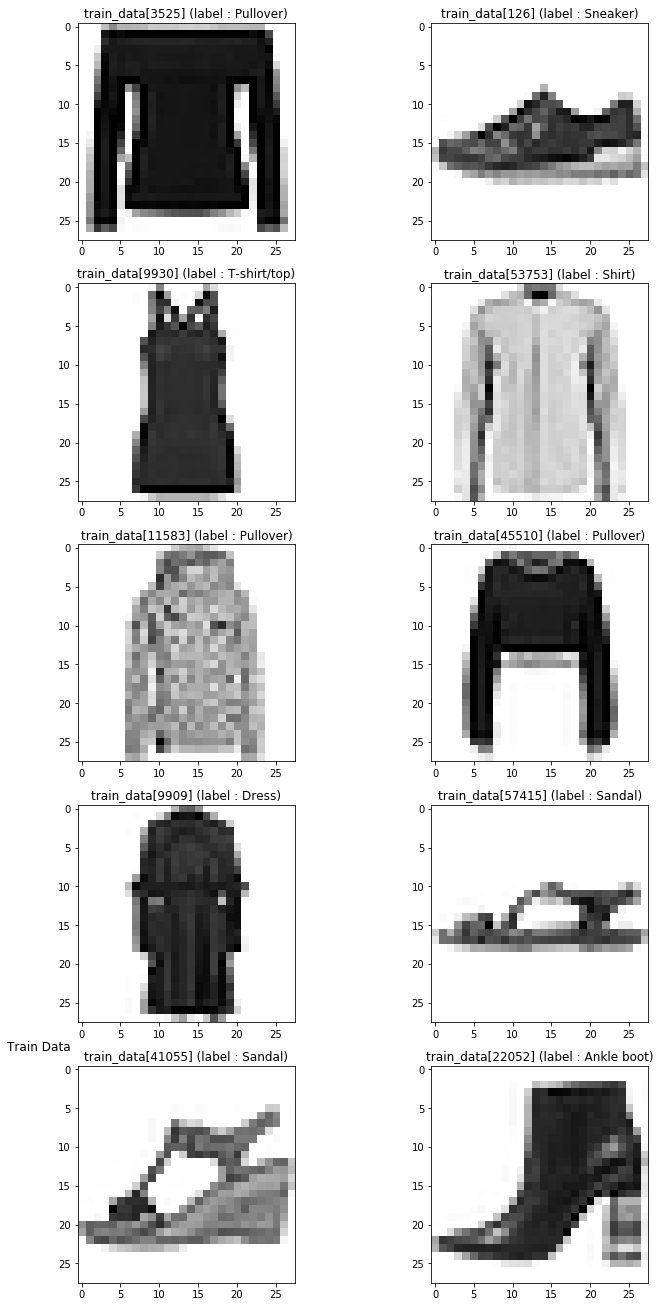

In [12]:
idx_show = np.arange(0, train_data.shape[0])
np.random.shuffle(idx_show)
true_or_false = idx_show[0:500]
idx_show = idx_show[0:10]
fig_train, ax_train = plt.subplots(5,2,figsize=(18, 7))
fig_train.suptitle("Train Data")
for idx in range(10):
    plt.subplots_adjust(left=0.5, right=1.0, top=3.0, bottom=0.5)
    ax_train[idx//2][idx%2].imshow(train_data[idx_show[idx]],cmap="binary")
    ax_train[idx//2][idx%2].set_title("train_data[{}] (label : {})".format(idx_show[idx], fashion_name[train_labels[idx_show[idx]][0]]))




> ## Plot



(0, 1.1)

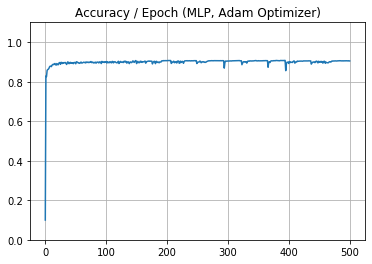

In [13]:
# Plot : Accuracy / Epoch
fig_accu, ax_accu = plt.subplots()
ax_accu.plot(arr_epoch, arr_accu)
ax_accu.set_title("Accuracy / Epoch (MLP, Adam Optimizer)")
ax_accu.grid(True)
ax_accu.set_ylim(0,1.1)

>## Training 이후

950


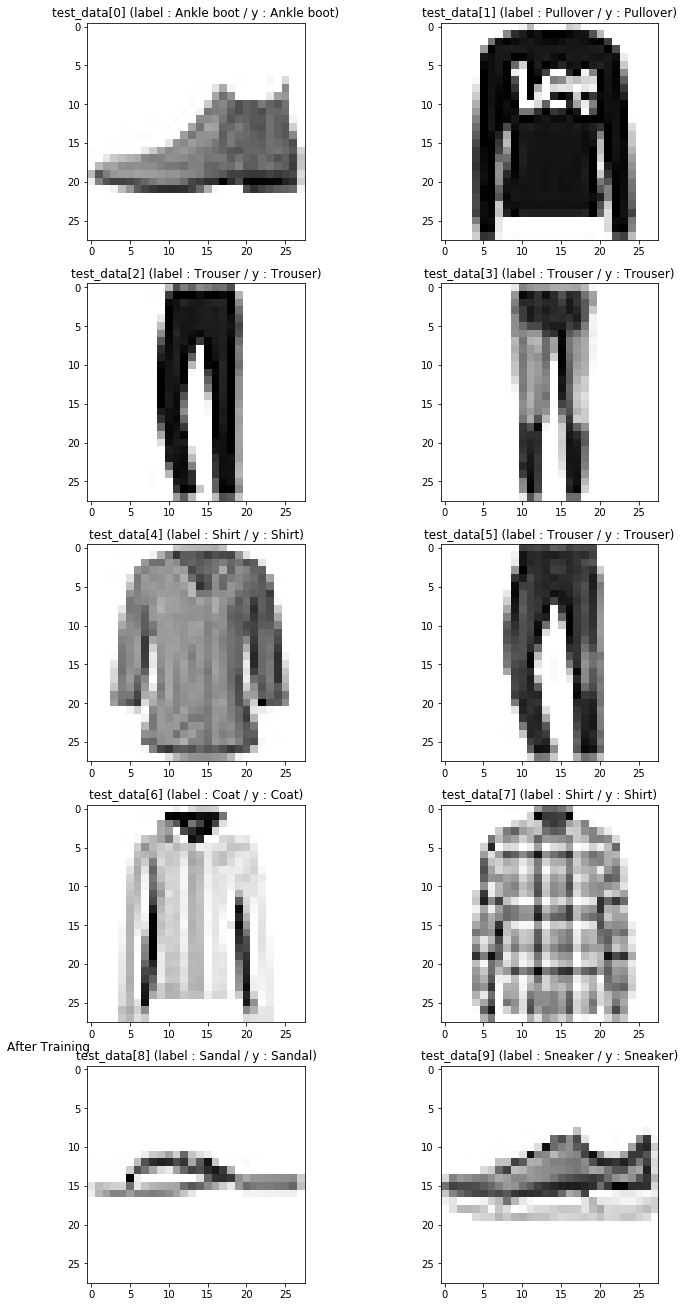

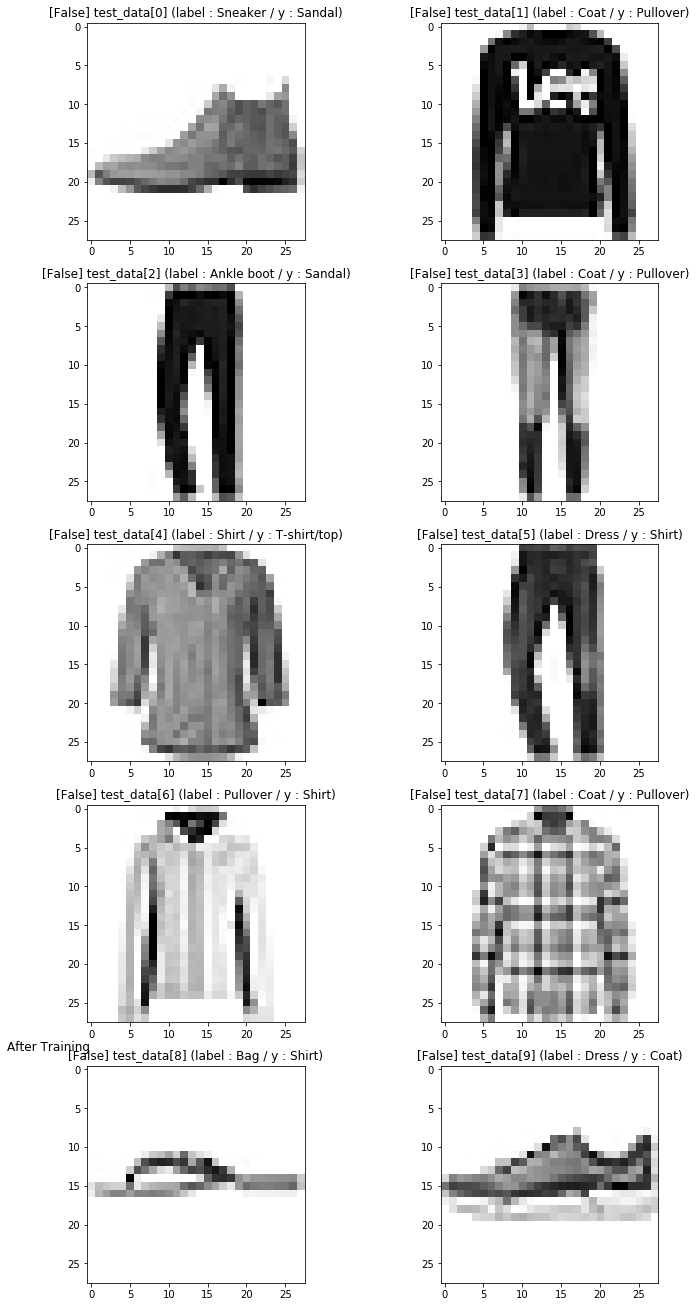

In [14]:
y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)
Make_Result_Plot_After_Training("After Training", test_data, test_labels, y_max)
